# Data preprocessing


#### The data is from a competition on the website : https://www.kaggle.com/c/facial-keypoints-detection  .
#### The objective of this task is to predict keypoint positions on face images. 

#### Our goal is using the face image pixel data to predict keypoint positions, and the data provides not only the pixel information but also some correct keypoints positions information. So we can use it to train and test the algorithm. 

#### We choose x/y coordinates of left eye center, right eye center and nose tip which are important facial keypoints as target variables.

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

df = pd.read_csv('D:/software/HW/FACE_REC/NEW/training.csv')

df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
df = df.dropna()
df = df[['left_eye_center_x']+['left_eye_center_y']+['right_eye_center_x']+['right_eye_center_y']+['Image']]

X = np.vstack(df['Image'].values) / 255. # normalized the pixel data
X = X.astype(np.float32)

df_y = df.drop(['Image'], axis=1)
Y= df_y.values.astype(np.float32)

df.tail(5)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,Image
2277,67.180378,35.816373,33.239956,34.921932,"[191.0, 191.0, 191.0, 190.0, 189.0, 185.0, 184..."
2278,65.724490,36.301020,25.377551,37.311224,"[19.0, 19.0, 19.0, 18.0, 13.0, 7.0, 3.0, 4.0, ..."
2281,68.430866,38.651975,28.895857,37.617027,"[31.0, 40.0, 47.0, 31.0, 54.0, 58.0, 63.0, 100..."
2282,64.152180,30.691592,27.000898,40.868082,"[7.0, 1.0, 5.0, 1.0, 3.0, 20.0, 12.0, 0.0, 5.0..."
2283,66.683755,34.483429,30.784490,38.578939,"[68.0, 19.0, 19.0, 23.0, 19.0, 26.0, 23.0, 16...."


#### To get valuable information from the image pixel data, we just keep the most 15% black pixels and making else white.

In [2]:
X_20 = np.percentile(X,15,axis=1)
for i in range(2140):
    for j in range(9216):
        if X[i,j] > X_20[i]:
            X[i,j] = 1
XX = X
X = X.reshape(-1,96,96)

In [3]:
%matplotlib inline

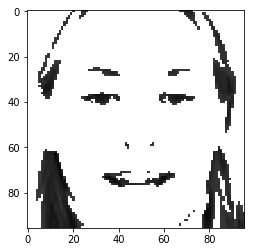

In [4]:
IM = XX[49] * 255
IM=IM.reshape(96,96)
plt.imshow(IM, cmap="gray")

#### From previous image shown, we can find that some marginal parts like hair are quite useless for our prediction. So we want to find a good 'mar', and cut the picture in four directions with 'mar' length. And we find 95% of images have good results when 'mar' is 15.

In [5]:
mar = []
for k in range(2140):
    count = 0
    for h in range(48):
        if np.any(X[k,h,h:-h-1] != 1) and np.any(X[k,95-h,h:-h-1] != 1) and np.any(X[k,h:-h-1,h] != 1) and np.any(X[k,h:-h-1,95-h] != 1):
            count += 1   # if there is pixel point not white in the margin line, we increase 'mar'. 
        else:
            mar.append(count)
            break
print(np.percentile(mar,95))

15.0


#### And then we get image after cutting, now we can pick up predictor variable from the image. we devide the image uniformly into four parts including left-up, left-bottom, right-up, right-bottom. And we use left-up and right-up parts usually containing eyes for prediction.
#### Then we pick up sum of pixel data and x/y coordinates of the most up, bottom, left and right points which are not white in both left-eye part and right-eye part.

In [6]:
X_left_eye = X[:,15:48,48:-15]
X_right_eye = X[:,15:48,15:48]
sum_l = X_left_eye.sum(axis = 1)
sum_left = sum_l.sum(axis = 1)
sum_r = X_right_eye.sum(axis = 1)
sum_right = sum_r.sum(axis = 1)


In [7]:
left_x_L = np.array([])
left_y_L = np.array([])
right_x_L = np.array([])
right_y_L = np.array([])
up_x_L = np.array([])
up_y_L = np.array([])
bottom_x_L = np.array([])
bottom_y_L = np.array([])
med_x_L = np.array([])
med_y_L = np.array([])

for i in range(2140):
    non_white = np.argwhere(X_left_eye[i]<1)
    if len(non_white) > 3:                                   # if the part containing more than 3 non_white pixel, we choose the fourth ones.
        sort_y = non_white[np.lexsort(non_white[:,::-1].T)]
        up_x_L = np.append(up_x_L,[sort_y[3,1]])
        up_y_L = np.append(up_y_L,[sort_y[3,0]])
        bottom_x_L = np.append(bottom_x_L,[sort_y[-4,1]])
        bottom_y_L = np.append(bottom_y_L,[sort_y[-4,0]])
        
        sort_x = non_white[np.lexsort(non_white.T)]
        left_x_L = np.append(left_x_L,[sort_x[3,1]])
        left_y_L = np.append(left_y_L,[sort_x[3,0]])
        right_x_L = np.append(right_x_L,[sort_x[-4,1]])
        right_y_L = np.append(right_y_L,[sort_x[-4,0]])
        
        med = np.median(non_white, axis = 0)
        med_x_L = np.append(med_x_L,[med[1]])
        med_y_L = np.append(med_y_L,[med[0]])
        
    if len(non_white) > 0 and len(non_white) < 4:         # if the part containg 1,2 or 3 non_white pixel, we just choose the first points.
        sort_y = non_white[np.lexsort(non_white[:,::-1].T)]
        up_x_L = np.append(up_x_L,[sort_y[0,1]])
        up_y_L = np.append(up_y_L,[sort_y[0,0]])
        bottom_x_L = np.append(bottom_x_L,[sort_y[-1,1]])
        bottom_y_L = np.append(bottom_y_L,[sort_y[-1,0]])
        
        sort_x = non_white[np.lexsort(non_white.T)]
        left_x_L = np.append(left_x_L,[sort_x[0,1]])
        left_y_L = np.append(left_y_L,[sort_x[0,0]])
        right_x_L = np.append(right_x_L,[sort_x[-1,1]])
        right_y_L = np.append(right_y_L,[sort_x[-1,0]])
        
        med = np.median(non_white, axis = 0)
        med_x_L = np.append(med_x_L,[med[1]])
        med_y_L = np.append(med_y_L,[med[0]])
        
    if len(non_white) ==0 :                             # if the part containg no non_white pixel, we just put NAN and then we will drop them.
        up_x_L = np.append(up_x_L,np.nan)
        up_y_L = np.append(up_y_L,np.nan)
        bottom_x_L = np.append(bottom_x_L,np.nan)
        bottom_y_L = np.append(bottom_y_L,np.nan)
        left_x_L = np.append(left_x_L,np.nan)
        left_y_L = np.append(left_y_L,np.nan)
        right_x_L = np.append(right_x_L,np.nan)
        right_y_L = np.append(right_y_L,np.nan)
        med_x_L = np.append(med_x_L,np.nan)
        med_y_L = np.append(med_y_L,np.nan)



In [8]:
left_x_R = np.array([])
left_y_R = np.array([])
right_x_R = np.array([])
right_y_R = np.array([])
up_x_R = np.array([])
up_y_R = np.array([])
bottom_x_R = np.array([])
bottom_y_R = np.array([])
med_x_R = np.array([])
med_y_R = np.array([])

for i in range(2140):
    non_white = np.argwhere(X_right_eye[i]<1)
    if len(non_white) > 3:                                 # if the part containg 1,2 or 3 non_white pixel, we just choose the first points.
        sort_y = non_white[np.lexsort(non_white[:,::-1].T)]
        up_x_R = np.append(up_x_R,[sort_y[3,1]])
        up_y_R = np.append(up_y_R,[sort_y[3,0]])
        bottom_x_R = np.append(bottom_x_R,[sort_y[-4,1]])
        bottom_y_R = np.append(bottom_y_R,[sort_y[-4,0]])
        
        sort_x = non_white[np.lexsort(non_white.T)]
        left_x_R = np.append(left_x_R,[sort_x[3,1]])
        left_y_R = np.append(left_y_R,[sort_x[3,0]])
        right_x_R = np.append(right_x_R,[sort_x[-4,1]])
        right_y_R = np.append(right_y_R,[sort_x[-4,0]])
        
        med = np.median(non_white, axis = 0)
        med_x_R = np.append(med_x_R,[med[1]])
        med_y_R = np.append(med_y_R,[med[0]])
        
    if len(non_white) > 0 and len(non_white) < 4:          # if the part containing more than 3 non_white pixel, we choose the fourth ones.
        sort_y = non_white[np.lexsort(non_white[:,::-1].T)]
        up_x_R = np.append(up_x_R,[sort_y[0,1]])
        up_y_R = np.append(up_y_R,[sort_y[0,0]])
        bottom_x_R = np.append(bottom_x_R,[sort_y[-1,1]])
        bottom_y_R = np.append(bottom_y_R,[sort_y[-1,0]])
        
        sort_x = non_white[np.lexsort(non_white.T)]
        left_x_R = np.append(left_x_R,[sort_x[0,1]])
        left_y_R = np.append(left_y_R,[sort_x[0,0]])
        right_x_R = np.append(right_x_R,[sort_x[-1,1]])
        right_y_R = np.append(right_y_R,[sort_x[-1,0]])
        
        med = np.median(non_white, axis = 0)
        med_x_R = np.append(med_x_R,[med[1]])
        med_y_R = np.append(med_y_R,[med[0]])
        
    if len(non_white) ==0 :                              # if the part containg no non_white pixel, we just put NAN and then we will drop them.
        up_x_R = np.append(up_x_R,np.nan)
        up_y_R = np.append(up_y_R,np.nan)
        bottom_x_R = np.append(bottom_x_R,np.nan)
        bottom_y_R = np.append(bottom_y_R,np.nan)
        left_x_R = np.append(left_x_R,np.nan)
        left_y_R = np.append(left_y_R,np.nan)
        right_x_R = np.append(right_x_R,np.nan)
        right_y_R = np.append(right_y_R,np.nan)
        med_x_R = np.append(med_x_R,np.nan)
        med_y_R = np.append(med_y_R,np.nan)



In [9]:
arr_x = np.vstack((up_x_R,up_y_R,bottom_x_R,bottom_y_R,left_x_R,left_y_R,right_x_R,right_y_R,med_x_R,med_y_R
                  ,up_x_L,up_y_L,bottom_x_L,bottom_y_L,left_x_L,left_y_L,right_x_L,right_y_L,med_x_L,med_y_L,sum_left,sum_right))
arr_x = arr_x.astype(np.float32)
arr_x = np.transpose(arr_x)
df_x = pd.DataFrame(arr_x,columns=['up_x_R','up_y_R','bottom_x_R','bottom_y_R','left_x_R','left_y_R','right_x_R','right_y_R','med_x_R','med_y_R'
                  ,'up_x_L','up_y_L','bottom_x_L','bottom_y_L','left_x_L','left_y_L','right_x_L','right_y_L','med_x_L','med_y_L',
                                   'sum_left','sum_right'])
df.index = range(0,len(df))
df_final = pd.concat([df_x,df],axis=1)
df_final = df_final.dropna()
df_final.index = range(0,len(df_final))
df_final.tail(5)

,up_x_R,up_y_R,bottom_x_R,bottom_y_R,left_x_R,left_y_R,right_x_R,right_y_R,med_x_R,med_y_R,...,right_y_L,med_x_L,med_y_L,sum_left,sum_right,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,Image
1950,0.0,1.0,27.0,27.0,0.0,3.0,27.0,27.0,12.0,16.0,...,14.0,19.0,17.0,1003.678406,958.772583,67.180378,35.816373,33.239956,34.921932,"[191.0, 191.0, 191.0, 190.0, 189.0, 185.0, 184..."
1951,7.0,20.0,15.0,14.0,15.0,14.0,8.0,20.0,14.0,14.0,...,21.0,21.5,20.0,1087.133301,1084.337158,65.724490,36.301020,25.377551,37.311224,"[19.0, 19.0, 19.0, 18.0, 13.0, 7.0, 3.0, 4.0, ..."
1952,10.0,12.0,6.0,24.0,1.0,15.0,22.0,15.0,12.0,15.0,...,17.0,25.0,18.0,1017.807861,1024.607910,68.430866,38.651975,28.895857,37.617027,"[31.0, 40.0, 47.0, 31.0, 54.0, 58.0, 63.0, 100..."
1953,3.0,0.0,11.0,26.0,0.0,3.0,11.0,25.0,3.0,4.0,...,16.0,14.5,15.5,1087.101929,1025.764648,64.152180,30.691592,27.000898,40.868082,"[7.0, 1.0, 5.0, 1.0, 3.0, 20.0, 12.0, 0.0, 5.0..."
1954,3.0,0.0,8.0,24.0,0.0,3.0,18.0,16.0,5.0,6.0,...,17.0,18.0,17.0,1077.047119,1005.047119,66.683755,34.483429,30.784490,38.578939,"[68.0, 19.0, 19.0, 23.0, 19.0, 26.0, 23.0, 16...."


In [10]:
df_final_1 = df_final.drop(['Image'], axis=1)
df_final_1.to_csv("D:/software/HW/FACE_REC/NEW/final_data_1.csv" , encoding = "utf-8")

In [11]:
df_final_2 = np.vstack(df_final['Image'].values)
np.set_printoptions(threshold=np.NaN)
np.savetxt("D:/software/HW/FACE_REC/NEW/final_data_2.txt",df_final_2)